##  Import libraries

In [30]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import preprocessing
from imblearn.metrics import geometric_mean_score
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
from qns3vm import QN_S3VM
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.semi_supervised import LabelPropagation
import os
import random
import sys
import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
np.set_printoptions(threshold=sys.maxsize)

## Import data files


In [5]:
file_tra = 'data/phoneme-ssl40-10-1tra.dat'
file_trs = 'data/phoneme-ssl40-10-1trs.dat'
file_tst = 'data/phoneme-ssl40-10-1tst.dat'

In [6]:
attributes = ["Aa","Ao","Dcl","Iy","Sh","Class"]

In [7]:
df_tra = pd.read_csv(file_tra, sep=",", names=attributes, header=None)
df_trs = pd.read_csv(file_trs, sep=",", names=attributes, header=None)
df_tst = pd.read_csv(file_tst, sep=",", names=attributes, header=None)

* df_trs is the dataframe containing the training data having labels for each datapoint which will be used for supervised learning
* df_tra is the dataframe containing the training data having 60% datapoints labeled and 40% datapoints unlabeled 
* df_tst is the dataframe containing the testing data

In [8]:
print("Number of data points for semi-supervised learning:", df_tra.shape[0])
print("Number of data points for supervised learning:", df_trs.shape[0])
print("Number of data points for testing:", df_tst.shape[0])

Number of data points for semi-supervised learning: 4863
Number of data points for supervised learning: 4863
Number of data points for testing: 541


### Checking for missing values

#### i) for training set for semi-supervised models

In [9]:
print(df_tra.isnull().sum())

Aa       0
Ao       0
Dcl      0
Iy       0
Sh       0
Class    0
dtype: int64


#### ii) for training set for supervised models

In [10]:
print(df_trs.isnull().sum())

Aa       0
Ao       0
Dcl      0
Iy       0
Sh       0
Class    0
dtype: int64


#### iii) for testing set

In [11]:
print(df_tst.isnull().sum())

Aa       0
Ao       0
Dcl      0
Iy       0
Sh       0
Class    0
dtype: int64


As observed there is no missing data

## Exploratory Data Analysis

### Histogram for each attribute (classwise)

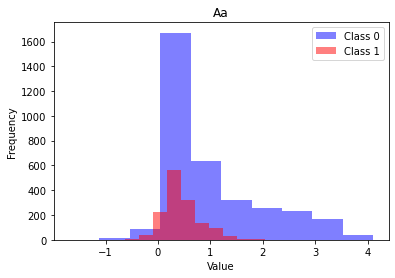

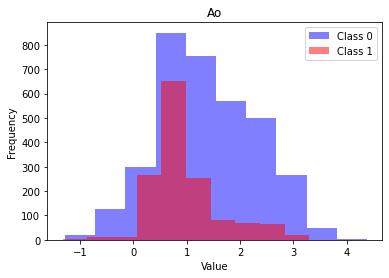

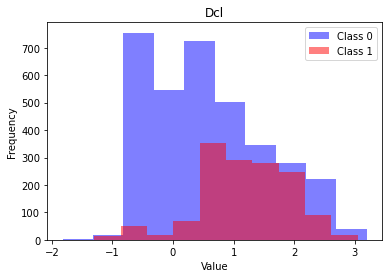

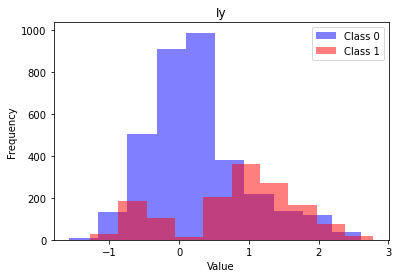

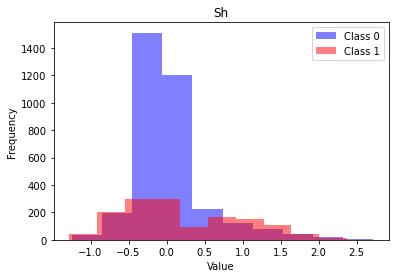

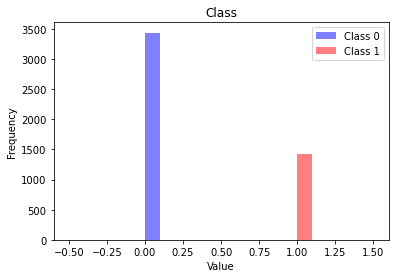

In [12]:
for i in range(len(attributes)):    
    x1 = df_trs.loc[df_trs.Class==0,attributes[i]]
    x2 = df_trs.loc[df_trs.Class==1,attributes[i]]

    plt.hist(x1, color='b', alpha=0.5, label='Class 0')
    plt.hist(x2, color='r', alpha=0.5, label='Class 1')
    plt.gca().set(title=attributes[i], xlabel='Value' ,ylabel='Frequency')
    plt.legend()
    plt.show()

### Heatmap

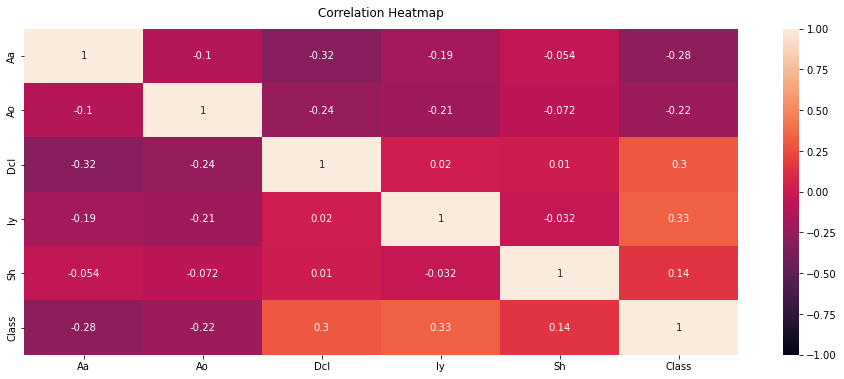

In [13]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_trs.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### Scatter Matrix

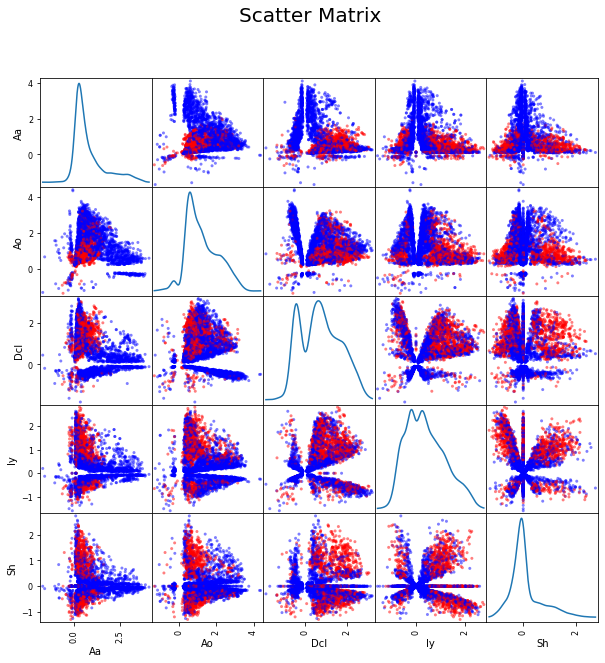

In [14]:
color_dict = {0:'blue', 1:'red'}
colors = [color_dict[x] for x in df_trs.values[:, -1]]
scatter_matrix(df_trs.iloc[:,:-1],figsize=(10, 10), diagonal='kde', color=colors)
plt.suptitle('Scatter Matrix', size = 20)
plt.show()

## Supervised Learning

### Class distribution

#### Training set (trs)

In [15]:
trs_occ = df_trs.Class.value_counts()
for i in range(len(trs_occ)):
    percentage = trs_occ[i]/df_trs.shape[0]
    percentage = round(percentage, 3)
    print("For Training set-> Class {}: Count={},
          Percentage of dataset={}".format(trs_occ.index[i],trs_occ[i], percentage))

For Training set-> Class 0: Count=3436, Percentage of dataset=0.707
For Training set-> Class 1: Count=1427, Percentage of dataset=0.293


#### Testing set (tst)

In [16]:
tst_occ = df_tst.Class.value_counts()
for i in range(len(tst_occ)):
    percentage = tst_occ[i]/df_tst.shape[0]
    percentage = round(percentage, 3)
    print("For Testing set-> Class {}: Count={},
          Percentage of dataset={}".format(tst_occ.index[i],tst_occ[i], percentage))

For Testing set-> Class 0: Count=382, Percentage of dataset=0.706
For Testing set-> Class 1: Count=159, Percentage of dataset=0.294


### Dividing into features and labels

In [17]:
X_trs = df_trs[['Aa','Ao','Dcl','Iy','Sh']]
Y_trs = df_trs[['Class']]
X_tst = df_tst[['Aa','Ao','Dcl','Iy','Sh']]
Y_tst = df_tst[['Class']]

### Standardizing

In [18]:
for column in X_trs.columns:
    X_trs[column] = (X_trs[column] - X_trs[column].mean()) / X_trs[column].std()
    
for column in X_tst.columns:
    X_tst[column] = (X_tst[column] - X_tst[column].mean()) / X_tst[column].std()

### Evaluation metrics

In [19]:
def model_evaluation(X,Y,model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
    gmscorer = make_scorer(geometric_mean_score)
    acc = make_scorer(accuracy_score)
    gmscore = cross_val_score(model, X_trs, Y_trs["Class"].values.tolist(), scoring=gmscorer, cv=cv, n_jobs=-1)
    accuracy = cross_val_score(model, X_trs, Y_trs["Class"].values.tolist(), scoring=acc, cv=cv, n_jobs=-1)
    mean_gmscore = np.round(gmscore.mean(),3)
    mean_accuracy = np.round(accuracy.mean(),3)
    return(mean_gmscore, mean_accuracy)

In [20]:
def confusion_matrix_display(Y_pred, Y_test, model_name):
    conf_matrix = confusion_matrix(Y_pred, Y_tst)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [0, 1])
    cm_display.plot(colorbar=False)
    fig = cm_display.ax_.get_figure()
    fig.set_figwidth(1)
    fig.set_figheight(1)
    plt.title("Confusion Matrix for {}".format(model_name), fontsize=8)
    plt.show()

### Supervised Learning models 

In [21]:
sl_model_names = ['Trivial_Classifier', 'Logistic_Regression', 'SVM linear kernel',
                  'SVM rbf kernel', 'Decision_Tree', 'Random_Forest']
sl_models = [DummyClassifier(strategy='uniform'),LogisticRegression(),
         SVC(kernel='linear'), SVC(kernel='rbf'), DecisionTreeClassifier(), RandomForestClassifier()]

#### Supervised Learning models for unbalanced data

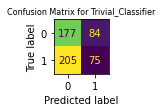

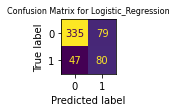

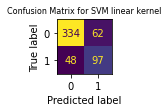

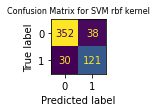

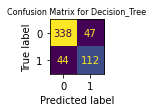

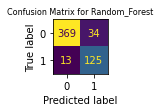

 Metrics for Unbalanced and Standarized Dataset for Supervised Learning Algorithms


,Name_of_model,Mean_Val_accuracy,Tst_accuracy,Mean_Val_GM_score,Tst_Gm_score
0,Trivial_Classifier,0.503,0.465804,0.497,0.426204
1,Logistic_Regression,0.748,0.767098,0.632,0.713946
2,SVM linear kernel,0.771,0.796673,0.699,0.751151
3,SVM rbf kernel,0.841,0.874307,0.801,0.850439
4,Decision_Tree,0.867,0.831793,0.837,0.793916
5,Random_Forest,0.907,0.913124,0.881,0.910702


In [22]:
row_list = []
for n in range(len(sl_models)):
    mean_val_gmscore, mean_val_accuracy = model_evaluation(X_trs, Y_trs, sl_models[n])
    sl_models[n].fit(X_trs, Y_trs)
    Y_pred = sl_models[n].predict(X_tst)
    tst_gmscore = geometric_mean_score(Y_pred, Y_tst)
    tst_accuracy = accuracy_score(Y_pred, Y_tst)
    row = {'Name_of_model': sl_model_names[n], 'Mean_Val_accuracy': mean_val_accuracy,
           'Tst_accuracy': tst_accuracy, 'Mean_Val_GM_score':mean_val_gmscore,'Tst_Gm_score': tst_gmscore}
    row_list.append(row)
    confusion_matrix_display(Y_pred, Y_tst, sl_model_names[n])
    plt.show()
df_unbal_metrics = pd.DataFrame(row_list)
print(" Metrics for Unbalanced and Standarized Dataset for Supervised Learning Algorithms")
df_unbal_metrics

We can observe that the best model using the metrics is Random Forest Classifier. 
Balancing techniques will be tested using this classifier

The results suggest that the Random Forest Classifier model gives the best results. Hence trying to optimize

### Optimizing Best Model - Random Forest Classifier

In [23]:
best_model = RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [100,200,500,1000,1500],
    'max_features': ['sqrt','log2'],
    'criterion' :['gini', 'entropy']
}
CV_best_model = GridSearchCV(estimator = best_model, param_grid = param_grid,
                             scoring=make_scorer(geometric_mean_score), cv= 10, verbose=3)
CV_best_model.fit(X_trs, Y_trs)
best_n_estimator = CV_best_model.best_params_['n_estimators']
best_criterion = CV_best_model.best_params_['criterion']
best_max_feature = CV_best_model.best_params_['max_features']
print("Best n_estimators: {}, Best_criterion: {}, Best_max_features: {}".format(best_n_estimator,
                                                                                best_criterion,best_max_feature))

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV 1/10] END criterion=gini, max_features=sqrt, n_estimators=100;, score=0.877 total time=   0.5s
[CV 2/10] END criterion=gini, max_features=sqrt, n_estimators=100;, score=0.862 total time=   0.5s
[CV 3/10] END criterion=gini, max_features=sqrt, n_estimators=100;, score=0.859 total time=   0.5s
[CV 4/10] END criterion=gini, max_features=sqrt, n_estimators=100;, score=0.901 total time=   0.5s
[CV 5/10] END criterion=gini, max_features=sqrt, n_estimators=100;, score=0.888 total time=   0.5s
[CV 6/10] END criterion=gini, max_features=sqrt, n_estimators=100;, score=0.896 total time=   0.5s
[CV 7/10] END criterion=gini, max_features=sqrt, n_estimators=100;, score=0.911 total time=   0.5s
[CV 8/10] END criterion=gini, max_features=sqrt, n_estimators=100;, score=0.847 total time=   0.5s
[CV 9/10] END criterion=gini, max_features=sqrt, n_estimators=100;, score=0.922 total time=   0.5s
[CV 10/10] END criterion=gini, max_features=sq

[CV 3/10] END criterion=gini, max_features=log2, n_estimators=1000;, score=0.846 total time=   4.7s
[CV 4/10] END criterion=gini, max_features=log2, n_estimators=1000;, score=0.912 total time=   4.7s
[CV 5/10] END criterion=gini, max_features=log2, n_estimators=1000;, score=0.885 total time=   4.8s
[CV 6/10] END criterion=gini, max_features=log2, n_estimators=1000;, score=0.901 total time=   4.8s
[CV 7/10] END criterion=gini, max_features=log2, n_estimators=1000;, score=0.903 total time=   4.8s
[CV 8/10] END criterion=gini, max_features=log2, n_estimators=1000;, score=0.865 total time=   4.8s
[CV 9/10] END criterion=gini, max_features=log2, n_estimators=1000;, score=0.914 total time=   4.8s
[CV 10/10] END criterion=gini, max_features=log2, n_estimators=1000;, score=0.892 total time=   4.7s
[CV 1/10] END criterion=gini, max_features=log2, n_estimators=1500;, score=0.881 total time=   7.1s
[CV 2/10] END criterion=gini, max_features=log2, n_estimators=1500;, score=0.872 total time=   7.1s

[CV 4/10] END criterion=entropy, max_features=log2, n_estimators=200;, score=0.910 total time=   1.1s
[CV 5/10] END criterion=entropy, max_features=log2, n_estimators=200;, score=0.879 total time=   1.1s
[CV 6/10] END criterion=entropy, max_features=log2, n_estimators=200;, score=0.896 total time=   1.1s
[CV 7/10] END criterion=entropy, max_features=log2, n_estimators=200;, score=0.906 total time=   1.1s
[CV 8/10] END criterion=entropy, max_features=log2, n_estimators=200;, score=0.854 total time=   1.1s
[CV 9/10] END criterion=entropy, max_features=log2, n_estimators=200;, score=0.916 total time=   1.1s
[CV 10/10] END criterion=entropy, max_features=log2, n_estimators=200;, score=0.886 total time=   1.1s
[CV 1/10] END criterion=entropy, max_features=log2, n_estimators=500;, score=0.877 total time=   2.8s
[CV 2/10] END criterion=entropy, max_features=log2, n_estimators=500;, score=0.868 total time=   2.8s
[CV 3/10] END criterion=entropy, max_features=log2, n_estimators=500;, score=0.85

Balancing techniques will be tested using the optimized best classifier

In [24]:
best_model_name = ['Random Forest']
best_model = [RandomForestClassifier(n_estimators = best_n_estimator,
                                     criterion = best_criterion,max_features= best_max_feature,random_state=42)]

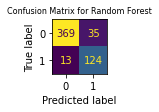

 Metrics for Unbalanced and Standarized Dataset for Supervised Learning Algorithms


,Name_of_model,Mean_Val_accuracy,Tst_accuracy,Mean_Val_GM_score,Tst_Gm_score
0,Random Forest,0.91,0.911275,0.884,0.909229


In [25]:
f1_row_list = []
for n in range(len(best_model)):
    mean_val_gmscore, mean_val_accuracy = model_evaluation(X_trs, Y_trs, best_model[n])
    best_model[n].fit(X_trs, Y_trs)
    Y_pred = best_model[n].predict(X_tst)
    tst_gmscore = geometric_mean_score(Y_pred, Y_tst)
    tst_accuracy = accuracy_score(Y_pred, Y_tst)
    row = {'Name_of_model': best_model_name[n], 'Mean_Val_accuracy': mean_val_accuracy,
           'Tst_accuracy': tst_accuracy, 'Mean_Val_GM_score':mean_val_gmscore,'Tst_Gm_score': tst_gmscore}
    f1_row_list.append(row)
    confusion_matrix_display(Y_pred, Y_tst, best_model_name[n])
    plt.show()
df_unbal_metrics = pd.DataFrame(f1_row_list)
print(" Metrics for Unbalanced and Standarized Dataset for Supervised Learning Algorithms")
df_unbal_metrics

### Supervised Learning models for balanced data

#### Balancing using Oversampling

In [26]:
from imblearn.over_sampling import SVMSMOTE

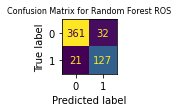

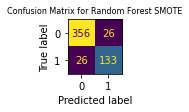

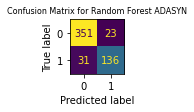

,Name_of_model,Name_of_os_algo,Mean_Val_accuracy,Tst_accuracy,Mean_Val_GM_score,Tst_Gm_score
0,Random Forest,ROS,0.906,0.902033,0.895,0.887827
1,Random Forest,SMOTE,0.901,0.903882,0.896,0.882918
2,Random Forest,ADASYN,0.893,0.900185,0.896,0.874237


In [27]:
metric_row_list = []
os_model_names = ['ROS','SMOTE','ADASYN']
os_models = [RandomOverSampler(), SMOTE(), ADASYN()]
for n in range(len(best_model)):
    for os_idx in range(len(os_models)):
        pipeline = Pipeline([('balancing',os_models[os_idx]),('model',best_model[n])])
        mean_val_gmscore, mean_val_accuracy = model_evaluation(X_trs, Y_trs.values.ravel(), pipeline)
        pipeline.fit(X_trs, Y_trs.to_numpy().reshape(-1,))
        Y_pred = pipeline.predict(X_tst).reshape(-1,1)
        tst_gmscore = geometric_mean_score(Y_pred, Y_tst)
        tst_accuracy = accuracy_score(Y_pred, Y_tst)
        row = {'Name_of_model': best_model_name[n], 'Name_of_os_algo': os_model_names[os_idx],
               'Mean_Val_accuracy': mean_val_accuracy,'Tst_accuracy': tst_accuracy,
               'Mean_Val_GM_score':mean_val_gmscore,'Tst_Gm_score': tst_gmscore}
        confusion_matrix_display(Y_pred, Y_tst, (best_model_name[n] +' ' +os_model_names[os_idx]))
        metric_row_list.append(row)
df_os_bal_acc = pd.DataFrame(metric_row_list)
df_os_bal_acc

#### Balancing using Undersampling

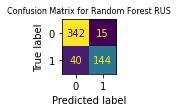

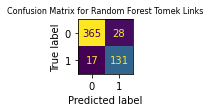

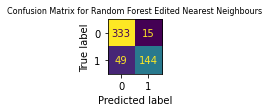

,Name_of_model,Name_of_us_algo,Mean_Val_accuracy,Tst_accuracy,Mean_Val_GM_score,Tst_Gm_score
0,Random Forest,RUS,0.872,0.898336,0.883,0.865867
1,Random Forest,Tomek Links,0.907,0.916821,0.889,0.906682
2,Random Forest,Edited Nearest Neighbours,0.867,0.881701,0.881,0.844958


In [28]:
metric_row_list = []
us_model_names = ['RUS','Tomek Links','Edited Nearest Neighbours']
us_models = [RandomUnderSampler(), TomekLinks(), EditedNearestNeighbours(n_neighbors=3)]
for n in range(len(best_model)):
    for us_idx in range(len(us_models)):
        pipeline = Pipeline([('balancing',us_models[us_idx]),('model',best_model[n])])
        mean_val_gmscore, mean_val_accuracy = model_evaluation(X_trs, Y_trs.values.ravel(), pipeline)
        pipeline.fit(X_trs, Y_trs.to_numpy().reshape(-1,))
        Y_pred = pipeline.predict(X_tst).reshape(-1,1)
        tst_gmscore = geometric_mean_score(Y_pred, Y_tst)
        tst_accuracy = accuracy_score(Y_pred, Y_tst)
        confusion_matrix_display(Y_pred, Y_tst, (best_model_name[n] +' ' + us_model_names[us_idx]))
        row = {'Name_of_model': best_model_name[n], 
               'Name_of_us_algo': us_model_names[us_idx],'Mean_Val_accuracy': mean_val_accuracy,
               'Tst_accuracy': tst_accuracy, 'Mean_Val_GM_score':mean_val_gmscore,'Tst_Gm_score': tst_gmscore}
        metric_row_list.append(row)
df_us_bal_acc = pd.DataFrame(metric_row_list)
df_us_bal_acc  

#### Balancing using Combined Sampling 

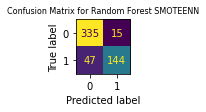

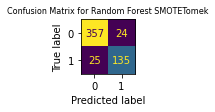

,Name_of_model,Name_of_com_algo,Mean_Val_accuracy,Tst_accuracy,Mean_Val_GM_score,Tst_Gm_score
0,Random Forest,SMOTEENN,0.860,0.885397,0.871,0.849480
1,Random Forest,SMOTETomek,0.901,0.909427,0.894,0.889157


In [31]:
metric_row_list = []
com_model_names = ['SMOTEENN','SMOTETomek']
com_models = [SMOTEENN(), SMOTETomek()]
for n in range(len(best_model)):
    for com_idx in range(len(com_models)):
        pipeline = Pipeline([('balancing',com_models[com_idx]),('model',best_model[n])])
        mean_val_gmscore, mean_val_accuracy = model_evaluation(X_trs, Y_trs.values.ravel(), pipeline)
        pipeline.fit(X_trs, Y_trs.to_numpy().reshape(-1,))
        Y_pred = pipeline.predict(X_tst).reshape(-1,1)
        tst_gmscore = geometric_mean_score(Y_pred, Y_tst)
        tst_accuracy = accuracy_score(Y_pred, Y_tst)
        confusion_matrix_display(Y_pred, Y_tst, (best_model_name[n] +' ' + com_model_names[com_idx]))
        row = {'Name_of_model': best_model_name[n], 'Name_of_com_algo': com_model_names[com_idx],
               'Mean_Val_accuracy': mean_val_accuracy,'Tst_accuracy': tst_accuracy,
               'Mean_Val_GM_score':mean_val_gmscore,'Tst_Gm_score': tst_gmscore}
        metric_row_list.append(row)
df_us_bal_acc = pd.DataFrame(metric_row_list)
df_us_bal_acc

## Semi-Supervised Learning

### Class distribution

In [66]:
tra_occ = df_tra.Class.value_counts()
for i in range(len(tra_occ)):
    percentage = tra_occ[i]/df_trs.shape[0]
    percentage = round(percentage, 3)
    print("For Training set for SSL -> Class {}: Count={}, Percentage of dataset={}".format(tra_occ.index[i],
                                                                                            tra_occ[i], percentage))

For Training set for SSL -> Class  unlabeled: Count=2918, Percentage of dataset=0.6
For Training set for SSL -> Class  0: Count=1386, Percentage of dataset=0.285
For Training set for SSL -> Class  1: Count=559, Percentage of dataset=0.115


In [67]:
tst_occ = df_tst.Class.value_counts()
for i in range(len(tst_occ)):
    percentage = tst_occ[i]/df_tst.shape[0]
    percentage = round(percentage, 3)
    print("For Testing set-> Class {}: Count={}, Percentage of dataset={}".format(tst_occ.index[i],
                                                                                  tst_occ[i], percentage))

For Testing set-> Class 0: Count=382, Percentage of dataset=0.706
For Testing set-> Class 1: Count=159, Percentage of dataset=0.294


### Dividing dataframe into Labeled and Unlabeled Dataframes

In [68]:
df_tra_unl = df_tra.loc[df_tra['Class'] == ' unlabeled' ]
df_tra_l = df_tra.loc[df_tra['Class'] != ' unlabeled']

### Dividing into features and labels

In [69]:
X_tra = df_tra[['Aa','Ao','Dcl','Iy','Sh']]
Y_tra = df_tra[['Class']]
X_tra_l = df_tra_l[['Aa','Ao','Dcl','Iy','Sh']]
Y_tra_l = df_tra_l[['Class']]
X_tra_unl = df_tra_unl[['Aa','Ao','Dcl','Iy','Sh']]
Y_tra_unl = df_tra_unl[['Class']]

### Standardizing 

In [70]:
for column in X_tra.columns:
    X_tra[column] = (X_tra[column] - X_tra[column].mean()) / X_tra[column].std()

for column in X_tra_unl.columns:
    X_tra_unl[column] = (X_tra_unl[column] - X_tra_unl[column].mean()) / X_tra_unl[column].std()
    
for column in X_tra_l.columns:
    X_tra_l[column] = (X_tra_l[column] - X_tra_l[column].mean()) / X_tra_l[column].std()

### Self Training

Changing the labels of the labeled data to int values

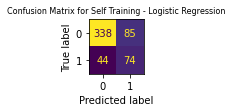

,Name_of_model,Train accuracy,Tst_accuracy,Train_GM_score,Tst_GM_score
0,Self Training - Logistic Regression,0.733087,0.761553,0.512541,0.641718


In [92]:
X_tra_mod1 = X_tra.copy()
Y_tra_mod1 = Y_tra.copy() 
Y_tra_mod1['Class'] = Y_tra_mod1['Class'].replace(' 0', 0)
Y_tra_mod1['Class'] = Y_tra_mod1['Class'].replace(' 1', 1)
X_tra_l_mod1 = X_tra_l.copy()
X_tra_unl_mod1 = X_tra_unl.copy()
Y_tra_l_mod1 = Y_tra_l.copy()
Y_tra_unl_mod1 = Y_tra_unl.copy()
Y_tra_l_mod1['Class'] = Y_tra_l_mod1['Class'].replace(' 0', 0)
Y_tra_l_mod1['Class'] = Y_tra_l_mod1['Class'].replace(' 1', 1)
Y_tra_unl_mod1['Class'] = Y_tra_unl_mod1['Class'].replace(' 0', 0)
Y_tra_unl_mod1['Class'] = Y_tra_unl_mod1['Class'].replace(' 1', 1)
row_list = []
iteration = 0

high_prob = [1]

while len(high_prob)>0:
    model = LogisticRegression()
    model.fit(X_tra_l_mod1, Y_tra_l_mod1)
    
    Y_pred_train = model.predict(X_tra_l_mod1)
    Y_pred_test = model.predict(X_tst)
    
    pred_probs = model.predict_proba(X_tra_unl_mod1)
    preds = model.predict(X_tra_unl_mod1)
    prob_0 = pred_probs[:,0]
    prob_1 = pred_probs[:,1]
    
    df_pred_prob = pd.DataFrame([])
    df_pred_prob['Class'] = preds
    df_pred_prob['prob_0'] = prob_0
    df_pred_prob['prob_1'] = prob_1
    df_pred_prob.index = X_tra_unl_mod1.index
    
    high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.75],
                           df_pred_prob.loc[df_pred_prob['prob_1'] > 0.75]],
                          axis=0)
    
    X_tra_l_mod1 = pd.concat([X_tra_l_mod1, X_tra_unl_mod1.loc[high_prob.index]], axis=0)

    Y_tra_l_mod1 = pd.concat([Y_tra_l_mod1, high_prob.Class.to_frame()])
    
    X_tra_unl_mod1 = X_tra_unl_mod1.drop(index=high_prob.index)
    Y_tra_unl_mod1 = Y_tra_unl_mod1.drop(index=high_prob.index)

Y_pred_train_append = Y_pred_train
Y_tra_unl_mod1['Class'] = Y_tra_unl_mod1['Class'].replace(' unlabeled', 0)         #Adhoc considering 0 for unlabeled 
Y_pred_train_append = np.append(Y_pred_train_append,Y_tra_unl_mod1.to_numpy())
X_tra_l_mod1_append = pd.concat([X_tra_l_mod1, X_tra_unl_mod1], axis=0)
res = []
Y_trs_arr = np.array(Y_trs.values.tolist()).reshape(-1,)
for idx in X_tra_l_mod1_append.index:
    res.append(Y_trs_arr[idx])
train_gmscore = geometric_mean_score(res, Y_pred_train_append)
test_gmscore = geometric_mean_score(Y_tst, Y_pred_test)
train_acc = accuracy_score(res, Y_pred_train_append)
test_acc = accuracy_score(Y_tst, Y_pred_test)
confusion_matrix_display(Y_pred_test, Y_tst,'Self Training - Logistic Regression')
row = {'Name_of_model': 'Self Training - Logistic Regression',
       'Train accuracy': train_acc,'Tst_accuracy': test_acc,
       'Train_GM_score':train_gmscore,'Tst_GM_score': test_gmscore}
row_list.append(row)
df_ssl = pd.DataFrame(row_list)
df_ssl


### Label Propagation

In [93]:
Y_tra_mod = Y_tra.copy() 
Y_tra_mod['Class'] = Y_tra_mod['Class'].replace(' 0', 0)
Y_tra_mod['Class'] = Y_tra_mod['Class'].replace(' 1', 1)
Y_tra_mod['Class'] = Y_tra_mod['Class'].replace(' unlabeled', -1)

#### Using labeled and unlabeled data ( datapoints from df_tra) for training

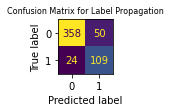

,Name_of_model,Train accuracy,Tst_accuracy,Train_GM_score,Tst_GM_score
0,Self Training - Logistic Regression,0.733087,0.761553,0.512541,0.641718
1,Label_Propagation,0.872000,0.863000,0.856000,0.848000


In [94]:
model = LabelPropagation(kernel='knn')
model.fit(X_tra, Y_tra_mod)
y_pred_tra = model.predict(X_tra)
trn_acc = np.round(accuracy_score(y_pred_tra, Y_trs),3)
trn_gmscore = np.round(geometric_mean_score(y_pred_tra, Y_trs),3)
y_pred = model.predict(X_tst)
tst_acc = np.round(accuracy_score(y_pred, Y_tst),3)
tst_gmscore = np.round(geometric_mean_score(y_pred, Y_tst),3)
confusion_matrix_display(y_pred, Y_tst,'Label Propagation')
row = {'Name_of_model': 'Label_Propagation','Train accuracy': trn_acc,
       'Tst_accuracy': tst_acc, 'Train_GM_score':trn_gmscore,'Tst_GM_score': tst_gmscore}
row_list.append(row)
df_ssl = pd.DataFrame(row_list)
df_ssl  



### Changing the labels of the labeled data to int values 

In [95]:
Y_tra_l['Class'] = Y_tra_l['Class'].replace(' 0',0)
Y_tra_l['Class'] = Y_tra_l['Class'].replace(' 1', 1)

#### Using labeled data to train SVM

In [96]:
model = SVC(kernel='linear', C=1.0)
model.fit(X_tra_l, Y_tra_l)
Y_pred_train = model.predict(X_trs)
Y_pred = model.predict(X_tst)
tra_acc = accuracy_score(Y_pred_train, Y_trs)
tst_acc = accuracy_score(Y_pred, Y_tst)
tra_gmscore = geometric_mean_score(Y_pred_train, Y_trs)
tst_gmscore = geometric_mean_score(Y_pred, Y_tst)
print("SVM model train accuracy on labeled data: {}".format(tra_acc))
print("SVM model test accuracy on labeled data: {}".format(tst_acc))
print("SVM model train GM score on labeled data: {}".format(tra_gmscore))
print("SVM model test GM score on labeled data: {}".format(tst_gmscore))

SVM model train accuracy on labeled data: 0.7629035574748098
SVM model test accuracy on labeled data: 0.7818853974121996
SVM model train GM score on labeled data: 0.705694326167012
SVM model test GM score on labeled data: 0.7345757714181504


#### Using labeled and unlabeled data for S3VM

Changing the labels of the labeled data to int values 

In [97]:
Y_tra_l_ssl = Y_tra_l.copy()
Y_tst_ssl = Y_tst.copy()
Y_trs_ssl  = Y_trs.copy()
Y_tra_l_ssl['Class'] = Y_tra_l_ssl['Class'].replace(0,-1)
Y_tst_ssl['Class'] = Y_tst['Class'].replace(0,-1)
Y_trs_ssl['Class'] = Y_trs['Class'].replace(0,-1)

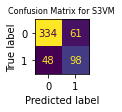

,Name_of_model,Train accuracy,Tst_accuracy,Train_GM_score,Tst_GM_score
0,Self Training - Logistic Regression,0.733087,0.761553,0.512541,0.641718
1,Label_Propagation,0.872000,0.863000,0.856000,0.848000
2,S3VM,0.773802,0.798521,0.719059,0.753375


In [98]:
model = QN_S3VM(X_tra_l.values.tolist(),
               Y_tra_l_ssl['Class'].values.tolist(),
               X_tra_unl.values.tolist(),
               random.Random())
model.train()
Y_pred_train = model.getPredictions(X_trs.values.tolist())
trn_acc = accuracy_score(Y_pred_train, Y_trs_ssl)
trn_gmscore = geometric_mean_score(Y_pred_train, Y_trs_ssl)
Y_pred = model.getPredictions(X_tst.values.tolist())
tst_acc = accuracy_score(Y_pred, Y_tst_ssl)
tst_gmscore = geometric_mean_score(Y_pred, Y_tst_ssl)
for i in range(len(Y_pred)):
    if(Y_pred[i] == -1):
        Y_pred[i] = 0
confusion_matrix_display(Y_pred, Y_tst, 'S3VM')
row = {'Name_of_model': 'S3VM','Train accuracy': trn_acc,'Tst_accuracy': tst_acc,
       'Train_GM_score':trn_gmscore,'Tst_GM_score': tst_gmscore}
row_list.append(row)
df_ssl = pd.DataFrame(row_list)
df_ssl  
